In [1]:
import pandas as pd
import numpy as np
import random
from glob import glob
import os
import re

import matplotlib.pyplot as plt

from graphviz import Source
import networkx as nx

from networkx.drawing.nx_agraph import graphviz_layout, to_agraph

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Get mutations probabilities from scRNAseq data
probabilities = pd.read_csv('../../data/YFV2001_matrix_output/0.0556.csv', sep=' ', header=None).stack().loc[lambda x : x >= 0.5].array


In [229]:
SCITE_path = '../../../mt-SCITE/mt-SCITE_output/Simulations/ground_truth/'

## Generate the ground truth pmats

In [123]:
def mutations_data(n_rows, clones, cells_per_clone, n_mutations, low_prob):
    np.random.seed(42)
    
    c = [f'c{w+1}' for w in range(clones)]
    s = [f's{w+1}' for w in range(cells_per_clone)]
    mux = pd.MultiIndex.from_product([c, s])
    
    # can define n_rows here from clones * cells_per_clone. But check that it does not mess up subclones stuffs
    # Write a test
    
    #Generate a dataframe with with default value
    gt = pd.DataFrame(low_prob, index=np.arange(n_rows) // n_mutations, columns=mux)
    
    # random assign 'X' for mutation by random index with no repeat
    for c, i in zip(gt.columns.levels[0], 
                    np.random.choice(np.unique(gt.index), clones, replace=False)):
        gt.loc[i, c] = 'X' 
    
    
    gt.columns = gt.columns.map(lambda clones: f'{clones[0]}_{clones[1]}')
    gt = gt.reset_index(drop=True)

    return gt

In [124]:
def generate_pmat(n_rows, clones, cells_per_clone, n_mutations, low_prob):
    
    # clonal mutations
    clonal = mutations_data(n_rows, clones, cells_per_clone, n_mutations, low_prob)
    cells = list(clonal.columns)
    
    #subclone1
    subclones1 = clones*2
    cells_per_subclones1 = cells_per_clone//2
    n_rows = subclones1 * n_mutations
    subclonal1 = mutations_data(n_rows, subclones1, cells_per_subclones1, n_mutations, low_prob)
    subclonal1.columns = cells
    
    frames = [clonal, subclonal1]
    pmat = pd.concat(frames, ignore_index=True)
    
    # Can put in sampling from probabilities here
    # Then add bulkis
    # replace 1.0
    # return shape

    
    return pmat

### Tree 1

In [220]:
np.random.seed(42)

clones = 6
cells_per_clone = 6
n_mutations = 1
low_prob = 0.0001 # no mutation
n_rows = clones * n_mutations

pmat = generate_pmat(n_rows, clones, cells_per_clone, n_mutations, low_prob)

pmat[pmat == 'X'] = np.random.choice(probabilities, size=pmat.shape, replace=True)
pmat.insert(loc=0, column='bulk', value=0.0001)

shape = pmat.shape

pmat = pmat.replace(1.0, 0.99999)

matrix_path = '../../data/simulations_matrix_output/ground_truth/tree1.csv'
pmat.to_csv(matrix_path, index=False, sep=' ', header= False)

# Check if values are rounded
#print (pmat.to_dict('list'))

#if 1.0 in pmat.values:
#    print("\nThis value exists in Dataframe")
#else :
#    print("\nThis value does not exists in Dataframe")

In [227]:
# Run mt-SCITE
tree_path = SCITE_path +'tree1/trees/tree1'
stdout_path = SCITE_path + 'tree1/stdout/tree1_stdout.txt'
n = shape[0]
m = shape[1]
#print(tree_path)

%timeit ! ../../../mt-SCITE/mt-SCITE/scite -i $matrix_path -n $n -m $m -r 1 -l 200000 -fd 0.0001 -ad 0.0001 -cc 0.0 -s -a -o $tree_path 1> $stdout_path


4.32 s ± 52.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


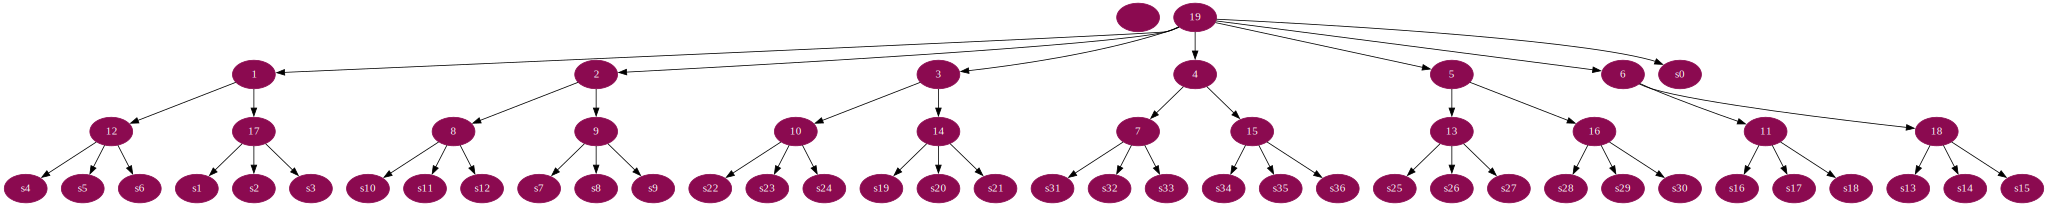

In [228]:
tree_filename = f'{tree_path}_map0.gv'
tree = nx.drawing.nx_pydot.read_dot(tree_filename)

g = to_agraph(tree)
g.layout('dot')
#g.draw(f'figs/trees/{error_rate}_map{tree_number}.pdf')
Source(g)

### Tree 2

In [230]:
pmat.shape

(18, 37)

In [231]:
# Remove subclonal mutations from half of the clones
# 6 clonal
# 12 subclonal
tree2 = pmat.copy()
tree2 = tree2.iloc[:-6]
shape = tree2.shape
matrix_path = '../../data/simulations_matrix_output/ground_truth/tree2.csv'
tree2.to_csv(matrix_path, index=False, sep=' ', header= False)
tree2.shape

(12, 37)

In [232]:
# Run mt-SCITE
tree_path = SCITE_path + 'tree2/trees/tree2'
stdout_path = SCITE_path + 'tree2/stdout/tree2_stdout.txt'
n = shape[0]
m = shape[1]

! ../../../mt-SCITE/mt-SCITE/scite -i $matrix_path -n $n -m $m -r 1 -l 200000 -fd 0.0001 -ad 0.0001 -cc 0.0 -s -a -o $tree_path 1> $stdout_path


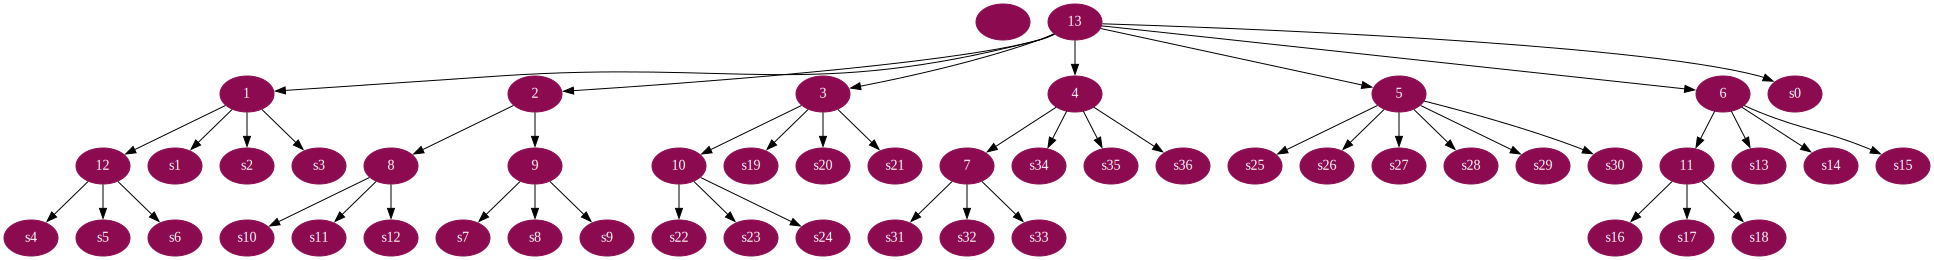

In [233]:
tree_filename = f'{tree_path}_map0.gv'
tree = nx.drawing.nx_pydot.read_dot(tree_filename)

g = to_agraph(tree)
g.layout('dot')
#g.draw(f'figs/trees/{error_rate}_map{tree_number}.pdf')
Source(g)

### Tree 3

In [234]:
# Remove subclonal mutations from all of the clones
# 6 clonal
# 12 subclonal
tree3 = pmat.copy()
tree3 = tree3.iloc[:-12]
shape = tree3.shape
matrix_path = '../../data/simulations_matrix_output/ground_truth/tree3.csv'
tree3.to_csv(matrix_path, index=False, sep=' ', header= False)
tree3.shape

(6, 37)

In [235]:
# Run mt-SCITE
tree_path = SCITE_path + 'tree3/trees/tree3'
stdout_path = SCITE_path + 'tree3/stdout/tree3_stdout.txt'
n = shape[0]
m = shape[1]

! ../../../mt-SCITE/mt-SCITE/scite -i $matrix_path -n $n -m $m -r 1 -l 200000 -fd 0.0001 -ad 0.0001 -cc 0.0 -s -a -o $tree_path 1> $stdout_path

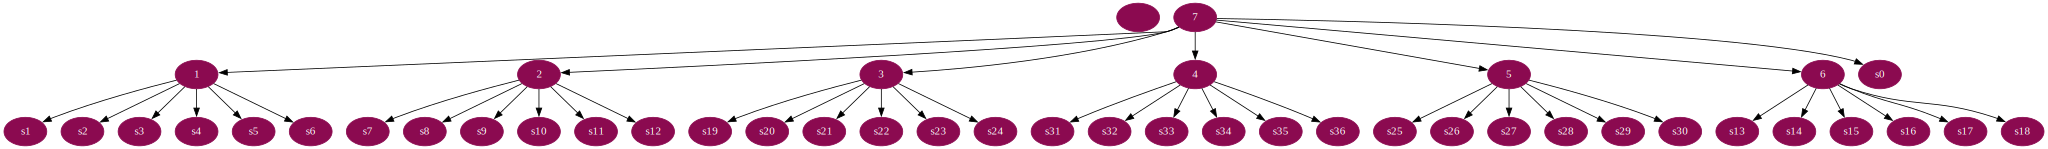

In [236]:
tree_filename = f'{tree_path}_map0.gv'
tree = nx.drawing.nx_pydot.read_dot(tree_filename)

g = to_agraph(tree)
g.layout('dot')
#g.draw(f'figs/trees/{error_rate}_map{tree_number}.pdf')
Source(g)

### Tree 4

In [237]:
# Remove 1 clonal
# 6 clonal
# 12 subclonal
tree4 = pmat.copy()
tree4 = tree4.iloc[:-13]
shape = tree4.shape
matrix_path = '../../data/simulations_matrix_output/ground_truth/tree4.csv'
tree4.to_csv(matrix_path, index=False, sep=' ', header= False)
tree4.shape

(5, 37)

In [238]:
# Run mt-SCITE
tree_path = SCITE_path + 'tree4/trees/tree4'
stdout_path = SCITE_path + 'tree4/stdout/tree4_stdout.txt'
n = shape[0]
m = shape[1]

! ../../../mt-SCITE/mt-SCITE/scite -i $matrix_path -n $n -m $m -r 1 -l 200000 -fd 0.0001 -ad 0.0001 -cc 0.0 -s -a -o $tree_path 1> $stdout_path


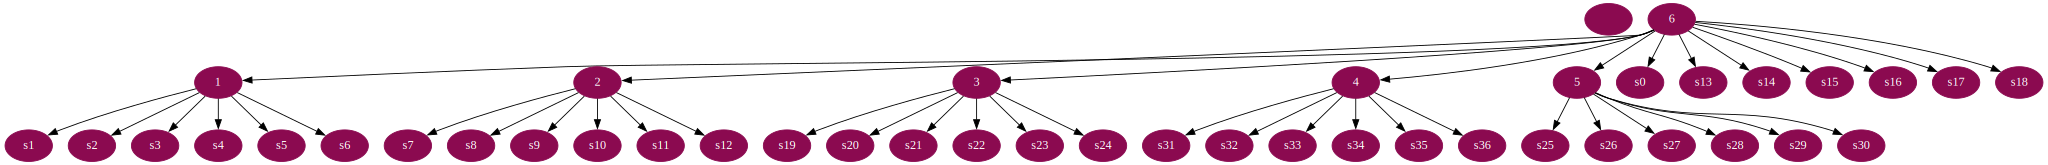

In [240]:
tree_filename = f'{tree_path}_map0.gv'
tree = nx.drawing.nx_pydot.read_dot(tree_filename)

g = to_agraph(tree)
g.layout('dot')
#g.draw(f'figs/trees/{error_rate}_map{tree_number}.pdf')
Source(g)

### Tree 5

In [241]:
# Remove 2 clonal
# 6 clonal
# 12 subclonal
tree5 = pmat.copy()
tree5 = tree5.iloc[:-14]
shape = tree5.shape
matrix_path = '../../data/simulations_matrix_output/ground_truth/tree5.csv'
tree5.to_csv(matrix_path, index=False, sep=' ', header= False)
tree5.shape

(4, 37)

In [242]:
# Run mt-SCITE
tree_path = SCITE_path + 'tree5/trees/tree5'
stdout_path = SCITE_path + 'tree5/stdout/tree5_stdout.txt'
n = shape[0]
m = shape[1]

! ../../../mt-SCITE/mt-SCITE/scite -i $matrix_path -n $n -m $m -r 1 -l 200000 -fd 0.0001 -ad 0.0001 -cc 0.0 -s -a -o $tree_path 1> $stdout_path


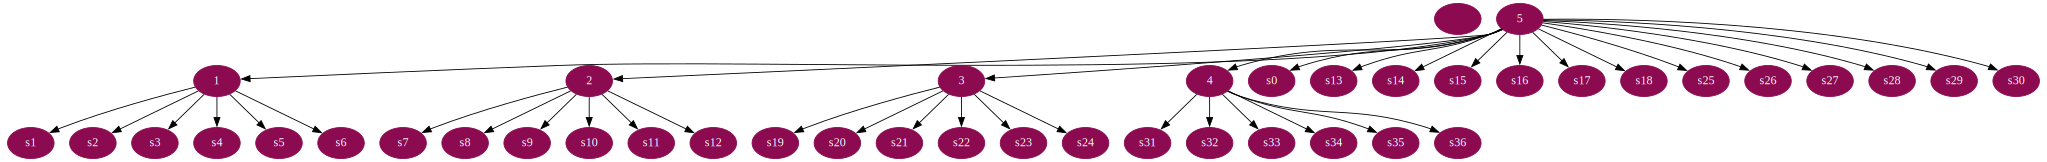

In [243]:
tree_filename = f'{tree_path}_map0.gv'
tree = nx.drawing.nx_pydot.read_dot(tree_filename)

g = to_agraph(tree)
g.layout('dot')
#g.draw(f'figs/trees/{error_rate}_map{tree_number}.pdf')
Source(g)

### Tree 6

In [244]:
# Remove 3 clonal
# 6 clonal
# 12 subclonal
tree6 = pmat.copy()
tree6 = tree6.iloc[:-15]
shape = tree6.shape
matrix_path = '../../data/simulations_matrix_output/ground_truth/tree6.csv'
tree6.to_csv(matrix_path, index=False, sep=' ', header= False)
tree6.shape

(3, 37)

In [245]:
# Run mt-SCITE
tree_path = SCITE_path + 'tree6/trees/tree6'
stdout_path = SCITE_path + 'tree6/stdout/tree6_stdout.txt'
n = shape[0]
m = shape[1]

! ../../../mt-SCITE/mt-SCITE/scite -i $matrix_path -n $n -m $m -r 1 -l 200000 -fd 0.0001 -ad 0.0001 -cc 0.0 -s -a -o $tree_path 1> $stdout_path


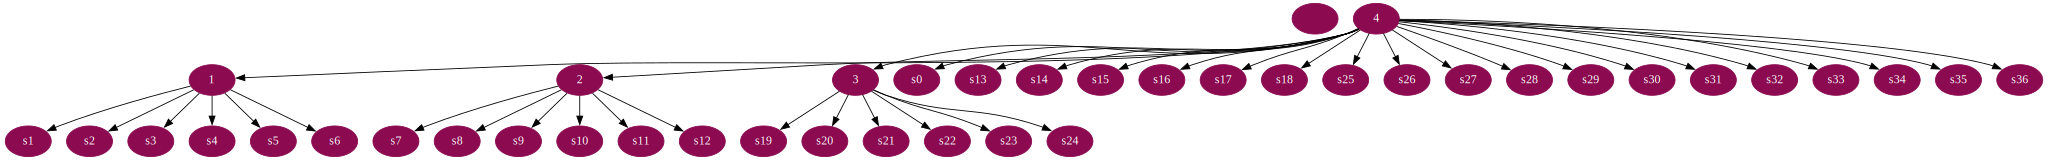

In [246]:
#tree_filename = f'{tree_path}_map0.gv'
tree_filename = f'{tree_path}_map0.gv'

tree = nx.drawing.nx_pydot.read_dot(tree_filename)

g = to_agraph(tree)
g.layout('dot')
#g.draw(f'figs/trees/{error_rate}_map{tree_number}.pdf')
Source(g)

## Add non-informative mutations

In [247]:

def add_noise(gt, ni_muts, tree):
    np.random.seed(42)
    
    i_muts = len(gt)
    
    # x is n cells sharing a non-informative phylo signal
    for x in range(2, 7):
        gt_w_noise = gt.copy()
        counter = 0
        
        # i is the number of added non-informative positions
        for i in range(1, ni_muts+1):
            
            # until reaches the total len of the final df
            if len(gt_w_noise) != i_muts + ni_muts:
                counter+=1
                
                # add new row with low probability for mutation
                gt_w_noise.loc[-1,:] = 0.0001

                # reset index
                gt_w_noise = gt_w_noise.reset_index(drop=True)

                # assign high probability to x randomly selected cells on last row
                # test if random seed works here
                np.random.seed(42)
                
                # TODO: sample mutations probabilities from scRNAseq
                gt_w_noise.iloc[-1:, random.sample(list(range(gt_w_noise.shape[1])), x)] = 0.99
                #print(len(gt_w_noise))
                
                # n is number of added non-informative positions
                n = str(counter)
                
        #return gt_w_noise

                
                matrix_path = '../../data/simulations_matrix_output/' + tree + '_' + str(x) + '_cells_' + n + '_pos.csv'
                gt_w_noise.to_csv(matrix_path, index=False, sep=' ', header= False)
                #print(len(gt_w_noise))

In [248]:
# non-informative mutations to add
ni_muts = 12

# Generate pmats with non-informative mutations
add_noise(pmat, ni_muts, 'tree1')
add_noise(tree2, ni_muts, 'tree2')
add_noise(tree3, ni_muts, 'tree3')
add_noise(tree4, ni_muts, 'tree4')
add_noise(tree5, ni_muts, 'tree5')
add_noise(tree6, ni_muts, 'tree6')

In [148]:
# Test run noise NEEDS to be changed!

# Run mt-SCITE
file = '../../data/simulations_matrix_output/tree6_6_cells_3_pos.csv'
tree_path = '../../../mt-SCITE/mt-SCITE_output/Simulation_v2/tree6/trees/tree6_6_cells_3_pos'
stdout_path = '../../../mt-SCITE/mt-SCITE_output/Simulation_v2/tree6/stdout/tree6_6_cells_3_pos_stdout.txt'

! ../../../mt-SCITE/mt-SCITE/scite -i $file -n 6 -m 37 -r 1 -l 200000 -fd 0.0001 -ad 0.0001 -cc 0.0 -s -a -o $tree_path 1> $stdout_path


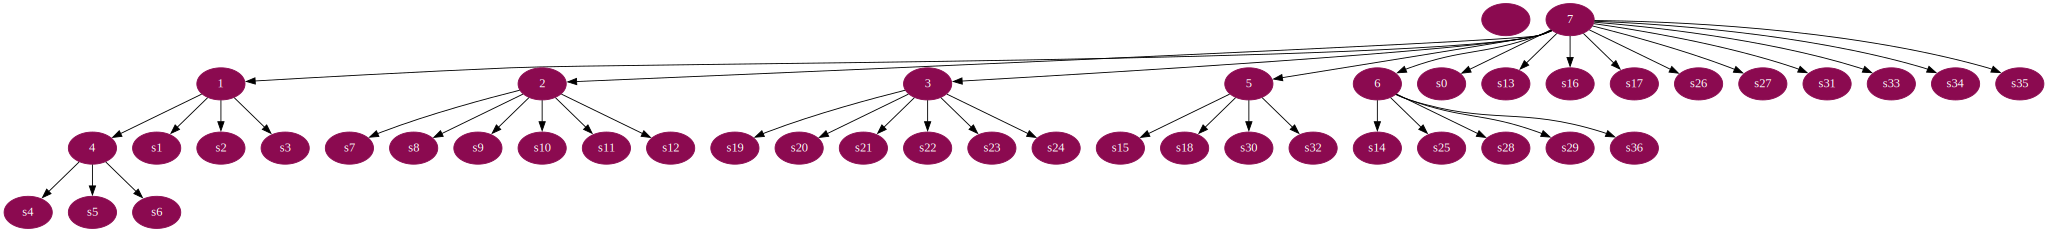

In [149]:
#tree_filename = f'{tree_path}_map0.gv'
tree_filename = f'{tree_path}_map0.gv'

tree = nx.drawing.nx_pydot.read_dot(tree_filename)

g = to_agraph(tree)
g.layout('dot')
#g.draw(f'figs/trees/{error_rate}_map{tree_number}.pdf')
Source(g)

### Bash commands

In [250]:
a_pmat = pd.read_csv('../../data/simulations_matrix_output/ground_truth/tree1.csv', sep=' ', header=None)
a_pmat.shape

(18, 37)

In [251]:
pmat_names = []
shapes = []

pmat_input_path = '../../data/simulations_matrix_output'
pmats = list(glob(os.path.join(pmat_input_path, '*.csv')))
tree_name = []

for filename in sorted(pmats, key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]):
    name = os.path.basename(filename).split('-')[0].rsplit('.', 2)[0]
    pmat_names.append(name)
    df = pd.read_csv(filename, sep=' ', header=None)
    shapes.append(len(df))

# make df with pmat info
pmat_data = pd.DataFrame(
    {'pmat_names': pmat_names,
     'len': shapes,
    })
    

In [252]:
pmat_data['tree_name'] = pmat_data.pmat_names.str[:5]
pmat_data['cells_w_ni'] = pmat_data.pmat_names.str[6:13]
pmat_data

,pmat_names,len,tree_name,cells_w_ni
0,tree1_2_cells_1_pos,19,tree1,2_cells
1,tree1_2_cells_2_pos,20,tree1,2_cells
2,tree1_2_cells_3_pos,21,tree1,2_cells
3,tree1_2_cells_4_pos,22,tree1,2_cells
4,tree1_2_cells_5_pos,23,tree1,2_cells
...,...,...,...,...
355,tree6_6_cells_8_pos,11,tree6,6_cells
356,tree6_6_cells_9_pos,12,tree6,6_cells
357,tree6_6_cells_10_pos,13,tree6,6_cells
358,tree6_6_cells_11_pos,14,tree6,6_cells


In [259]:
PMAT_PATH = '../../mcmt/data/simulations_matrix_output/'
TREE_PATH = '../../mt-SCITE/mt-SCITE_output/Simulations/'
STDOUT_PATH = '../../mt-SCITE/mt-SCITE_output/Simulations/stdout/'

n_cells = '37'

for pmat in pmat_names:
    n = pmat_data.loc[pmat_data['pmat_names'] == pmat, 'len'].iloc[0].astype(str)
    tree_folder = pmat_data.loc[pmat_data['pmat_names'] == pmat, 'tree_name'].iloc[0]
    cells_w_ni = pmat_data.loc[pmat_data['pmat_names'] == pmat, 'cells_w_ni'].iloc[0]
    
    print('../mt-SCITE/scite -i '
          + PMAT_PATH
          + pmat + '.csv'
          + ' -n ' + n  
          + ' -m ' + n_cells
          + ' -r 1 -l 200000 -fd 0.0001 -ad 0.0001 -cc 0.0 -s -a -o '
          + TREE_PATH
          + tree_folder + '/'
          + cells_w_ni + '/'
          + pmat
          + ' 1> ' + STDOUT_PATH
          + pmat + '.stdout.txt'
         )

          
    

../mt-SCITE/scite -i ../../mcmt/data/simulations_matrix_output/tree1_2_cells_1_pos.csv -n 19 -m 37 -r 1 -l 200000 -fd 0.0001 -ad 0.0001 -cc 0.0 -s -a -o ../../mt-SCITE/mt-SCITE_output/Simulations/tree1/2_cells/tree1_2_cells_1_pos 1> ../../mt-SCITE/mt-SCITE_output/Simulations/stdout/tree1_2_cells_1_pos.stdout.txt
../mt-SCITE/scite -i ../../mcmt/data/simulations_matrix_output/tree1_2_cells_2_pos.csv -n 20 -m 37 -r 1 -l 200000 -fd 0.0001 -ad 0.0001 -cc 0.0 -s -a -o ../../mt-SCITE/mt-SCITE_output/Simulations/tree1/2_cells/tree1_2_cells_2_pos 1> ../../mt-SCITE/mt-SCITE_output/Simulations/stdout/tree1_2_cells_2_pos.stdout.txt
../mt-SCITE/scite -i ../../mcmt/data/simulations_matrix_output/tree1_2_cells_3_pos.csv -n 21 -m 37 -r 1 -l 200000 -fd 0.0001 -ad 0.0001 -cc 0.0 -s -a -o ../../mt-SCITE/mt-SCITE_output/Simulations/tree1/2_cells/tree1_2_cells_3_pos 1> ../../mt-SCITE/mt-SCITE_output/Simulations/stdout/tree1_2_cells_3_pos.stdout.txt
../mt-SCITE/scite -i ../../mcmt/data/simulations_matrix_ou